In [223]:
import pandas as pd
import torch
from torch import nn, optim
from scipy.io import arff
import numpy as np

In [224]:
def read_arrf(file):
    with open(file, encoding="utf-8") as f:
        header = []
        for line in f:
            if line.startswith("@attribute"):
                header.append(line.split(sep='\'')[1])
            elif line.startswith("@data"):
                break
        df = pd.read_csv(f, header=None)
        df.columns = header
    return df

In [225]:
train_df = read_arrf("../NSL-KDD/KDDTrain+.arff")
test_df = read_arrf('../NSL-KDD/KDDTest+.arff')
train_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [226]:
# 获取行数
total_rows = train_df.shape[0]

# 准备一个用于保存修改后的数据集的列表
poisoned_datasets = []

df = train_df.copy()

# 循环取出2%, 4%, 6%, 8%, 10%的数据
for i in range(1, 4):
    # 计算要取出的行数
    rows = int(total_rows * i * 2 / 100)
    
    # 创建数据的一个新的副本
    df_copy = df.copy()
    
    # 取出数据
    subset_df = df_copy.iloc[:rows]

    # 将所有数值型属性的值修改为5000
    numeric_cols = subset_df.select_dtypes(include='number').columns
    subset_df.loc[:, numeric_cols] = 5000
    
    # 替换回原始数据集的相应位置
    df_copy.update(subset_df)
    
    # 将修改后的数据集保存到列表中
    poisoned_datasets.append(df_copy)

# poisoned_datasets 现在包含了5个数据集，每个数据集的不同比例的数据已经被“投毒”

C:\Users\Lucy\AppData\Local\Temp\ipykernel_22816\4277435627.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df.loc[:, numeric_cols] = 5000


In [227]:
for i in range(0, 3):
    poisoned_datasets[i] = poisoned_datasets[i].sample(frac=1.0, random_state=42)

In [228]:
test_df = test_df.sample(frac=1.0, random_state=42)
test_df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
6186,0,tcp,smtp,SF,914,329,0,0,0,0,...,155,0.61,0.06,0.00,0.00,0.00,0.00,0.01,0.01,normal
247,0,tcp,private,S0,0,0,0,0,0,0,...,2,0.01,0.07,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
4343,0,tcp,smtp,SF,1012,338,0,0,0,0,...,169,0.73,0.04,0.01,0.01,0.00,0.00,0.00,0.00,normal
17527,0,tcp,http,SF,243,667,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
13123,0,tcp,http,SF,227,286,0,0,0,0,...,255,1.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11964,0,tcp,telnet,S0,0,0,0,0,0,0,...,86,0.34,0.01,0.00,0.02,1.00,1.00,0.00,0.00,anomaly
21575,0,tcp,kshell,S0,0,0,0,0,0,0,...,2,0.01,0.18,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
5390,1,tcp,imap4,RSTO,0,44,0,0,0,0,...,40,0.16,0.03,0.00,0.00,0.02,0.08,0.56,0.88,anomaly
860,282,tcp,ftp,SF,162,599,0,0,0,2,...,57,0.22,0.03,0.00,0.00,0.13,0.00,0.02,0.00,anomaly


In [229]:
pos_train_xs = []
pos_train_ys = []
pos_num_features = []
pos_one_hots = []

train_x = train_df.iloc[:, :-1]
test_x = test_df.iloc[:, :-1]
for i in range(0, 3):
    pos_train_xs.append(poisoned_datasets[i].iloc[:, :-1])
col_feature = train_x.dtypes[train_x.dtypes == 'object'].index
num_feature = train_x.dtypes[train_x.dtypes != 'object'].index

def min_max_normalization(data):
    #对原始数据进行min-max归一化处理
        max_val = max(data)
        min_val = min(data)
        if min_val == max_val:
            return data
        else:
            norm_data = [(x - min_val) / (max_val - min_val) for x in data]
            return norm_data

train_num_feature = train_x[num_feature].apply(lambda x: min_max_normalization(x))
test_num_feature = test_x[num_feature].apply(lambda x: min_max_normalization(x))
for i in range(0, 3):
    pos_num_features.append(pos_train_xs[i][num_feature].apply(lambda x: min_max_normalization(x)))

train_one_hot = pd.get_dummies(train_x[col_feature], dummy_na=True)
for i in range(0, 3):
    pos_one_hots.append(pd.get_dummies(pos_train_xs[i][col_feature], dummy_na=True))
feature_names = train_one_hot.columns
test_one_hot = pd.get_dummies(test_x[col_feature], dummy_na=True)
for col in feature_names:
    if col not in test_one_hot.columns:
        test_one_hot[col] = 0
# 调整特征的顺序
test_encoded = test_one_hot[feature_names]
train_y = train_df.iloc[:, -1]
test_y = test_df.iloc[:, -1]
for i in range(0, 3):
    pos_train_ys.append(poisoned_datasets[i].iloc[:, -1])

mapping = {'normal':0, 'anomaly':1}
train_y = train_y.map(mapping).T
test_y = test_y.map(mapping).T
for i in range(0, 3):
    pos_train_ys[i] = pos_train_ys[i].map(mapping).T

train_x = pd.concat([train_one_hot, train_num_feature], axis=1).values
test_x = pd.concat([test_one_hot, test_num_feature], axis=1).values
for i in range(0, 3):
    pos_train_xs[i] = pd.concat([pos_one_hots[i], pos_num_features[i]], axis=1).values

In [230]:
class LogisticRegression():
    def __init__(self, lr=0.005, max_iter=150, tol=1e-4):
        self.lr = lr
        self.max_iter = max_iter
        self.tol = tol
        self.w = None
        self.ll = []
        self.ll_test = []

    @staticmethod
    def sigmoid(z):
        z = np.clip(z, -100, 100)
        return 1 / (1 + np.exp(-z))

    
    def BCELoss(self,y_pred, y_true, eps=1e-7, pos_weight=None):
        m = y_pred.shape[0]
        if pos_weight is None:
            pos_weight = 0.5
        loss = -(pos_weight * y_true * np.log(y_pred + eps) + (1 - pos_weight) * (1 - y_true) * np.log(1 - y_pred + eps)).sum() / m
        return loss


    def fit(self, X, y,test_X, test_y):
        n, m = X.shape
        self.w = np.zeros(m)
        for i in range(self.max_iter):
            shuffled_indices = np.random.permutation(m)
            X_shuffled = X[shuffled_indices]
            y_shuffled = y[shuffled_indices]
            z = X_shuffled @ self.w
            h = self.sigmoid(z)
            gradient = X_shuffled.T @ (h - y_shuffled)
            self.w -= self.lr * gradient
            if np.linalg.norm(gradient) < self.tol:
                break
            # 在测试集上计算准确率和损失
            self.ll.append(self.BCELoss(h, y_shuffled))
            self.ll_test.append(self.BCELoss(self.sigmoid(test_X @ self.w), test_y))
            
    def predict(self, X):
        return np.round(self.sigmoid(X @ self.w))

In [231]:
# 计算精确率
def acc(y_true, y_predict):
    assert y_true.shape == y_predict.shape
    return np.sum(y_true==y_predict)/len(y_true)

In [232]:
# 增加偏置的特征列
train_x = np.concatenate((np.ones((train_x.shape[0],1)),train_x),axis=1)
test_x = np.concatenate((np.ones((test_x.shape[0],1)),test_x),axis=1)

In [233]:
# 用训练集训练
logistic_regression = LogisticRegression()
logistic_regression.fit(train_x, train_y,test_x,test_y)

In [234]:
y_predict = logistic_regression.predict(test_x)
test_acc=acc(test_y,y_predict)
print("Test Accuracy: {:.2f}%".format(test_acc * 100))

Test Accuracy: 79.18%


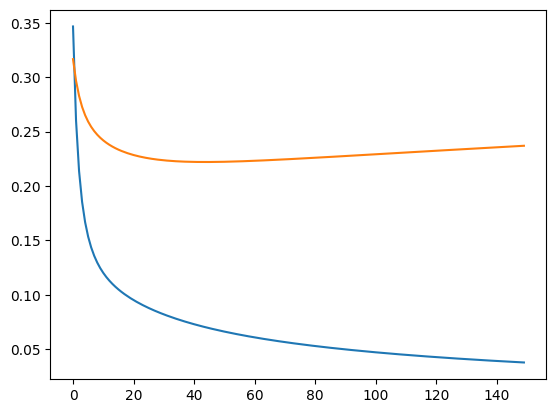

In [235]:
import matplotlib.pyplot as plt
plt.plot(logistic_regression.ll)
plt.plot(logistic_regression.ll_test)

### 投毒攻击

In [236]:
pos_acc = []
pos_acc.append(test_acc)

In [237]:
# 增加偏置的特征列
for i in range(0, 3):
    pos_train_xs[i]=np.concatenate((np.ones((pos_train_xs[i].shape[0],1)),pos_train_xs[i]),axis=1) 

In [238]:
pos_logistic_regression_0 = LogisticRegression()
pos_logistic_regression_0.fit(pos_train_xs[0], pos_train_ys[0],test_x,test_y)

pos_y_predict_0 = pos_logistic_regression_0.predict(test_x)
pos_acc_0=acc(test_y,pos_y_predict_0)

pos_acc.append(pos_acc_0)

print("Test Accuracy of 2% poison: {:.2f}%".format(pos_acc_0 * 100))

Test Accuracy of 2% poison: 46.32%


In [239]:
pos_logistic_regression_1 = LogisticRegression()
pos_logistic_regression_1.fit(pos_train_xs[1], pos_train_ys[1],test_x,test_y)

pos_y_predict_1 = pos_logistic_regression_1.predict(test_x)
pos_acc_1=acc(test_y,pos_y_predict_1)

pos_acc.append(pos_acc_1)

print("Test Accuracy of 4% poison: {:.2f}%".format(pos_acc_1 * 100))

Test Accuracy of 4% poison: 47.00%


In [240]:
pos_logistic_regression_2 = LogisticRegression()
pos_logistic_regression_2.fit(pos_train_xs[2], pos_train_ys[2],test_x,test_y)

pos_y_predict_2 = pos_logistic_regression_2.predict(test_x)
pos_acc_2=acc(test_y,pos_y_predict_2)

pos_acc.append(pos_acc_2)

print("Test Accuracy of 6% poison: {:.2f}%".format(pos_acc_2 * 100))

Test Accuracy of 6% poison: 47.19%


In [241]:
print(pos_acc)

[0.7917849538679915, 0.4631831085876508, 0.46996983676366216, 0.47192157558552167]


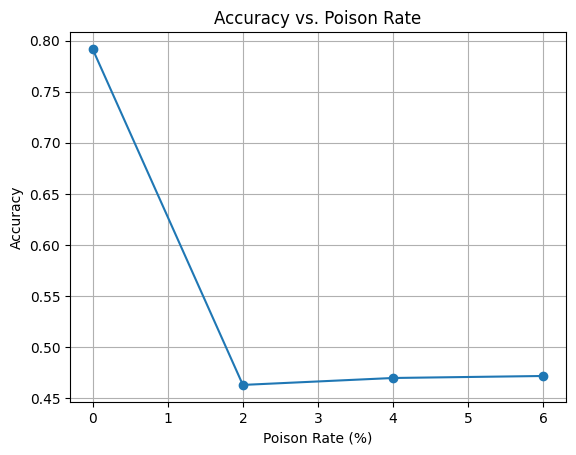

In [243]:
# 投毒率
poison_rates = [0, 2, 4, 6]

# 绘制图形
plt.plot(poison_rates, pos_acc, marker='o')

# 设置标题和坐标轴标签
plt.title('Accuracy vs. Poison Rate')
plt.xlabel('Poison Rate (%)')
plt.ylabel('Accuracy')

# 显示网格线
plt.grid(True)

# 显示图形
plt.show()
